In [1]:
using PyPlot, JLD
include("../src/gradientflow_tumor.jl"); 
#file = h5open("tumorgrowth.h5", "w")

gradientflow

In [115]:
#write(file, "comparespeed1D", A)
#data=file["comparespeed1D"]
#attrs(data)["param"] = "dim, N, τ, ϵ, niter = 1, 2000, 5e-2, 2e-7, 200"
#read(data["param"])

# Tumor growth as a gradient flow, S. Di Marino, L. Chizat

With the modelization of tumor growth in mind, [Perthame et al. '13] obtained the system
$$
\left\{
\begin{aligned}
    \partial_t \rho - \nabla \cdot (\rho \nabla p) &= 4(\lambda - p)\rho 
\\
p(1-\rho)&=0
\\
\rho(0,\cdot) &= \rho_0
\end{aligned}
\right.
$$
as a *stiff* limit of growth-diffusion-congestion processes (i.e. with infinite congestion effects). Here $\rho(t,x)$ is the density of bad cells, $p(t,x)$ the pressure with $t>0$ and $x\in \Omega \subset \mathbb{R}^d$.

We show that this model is the gradient flow of 
$$
G(\rho) = -\rho(\Omega) +\iota_{\leq 1}(\rho)
$$
in the space of nonnegative measures endowed with the $KF$ (Kantorovich-Fisher Rao) transport-growth metric, defined as
$$
KF^2(\mu,\nu) = \min_{\gamma \in \mathcal{M}_+(\Omega^2)} \langle c, \gamma \rangle+ \mathcal{H}(P^1_\# \gamma | \mu) + \mathcal{H}(P^2_\# \gamma | \nu) 
$$
with $c(x,y)=-\log \cos^2 (\min \{ |y-x|, \tfrac{\pi}{2} \})$ and $\mathcal{H}$ is the relative entropy.

This allows for a nice interpretation of this model as well as numerical methods for solving it.

## Theoretical analysis of the spherical case

The solution is explicit when the initial condition is a uniform density on a ball $\rho_0 = \chi_{B(r_0)}$ with $r_0>0$: it is of the form $\chi_{B(r(t)}$ and the pressure $p(s) (= p(|x|) )$ solves on $[-r(t),r(t)]$:
$$
\partial^2_s p+ \tfrac{d-1}{s}\partial_s p-\beta^2(p-\lambda)=0\, .
$$
where $\beta=2$ in our convention. This, plus the fact that $r'(t)=|\partial_s p(t,r)|$ leads to the implicit expression for $r(t)$:
$$
K_{d/2}(\beta r(t))= e^{\lambda \beta^2 t} K_{d/2}(\beta r(0)) \Leftrightarrow t = \tfrac{1}{\beta^2 \lambda} \log \left(\frac{K_{d/2}(\beta r)}{K_{d/2}(\beta r(0))} \right)
$$
where $K_\alpha(x)=x^\alpha I_\alpha(x)$ and $I_\alpha$ is the modified Bessel function of the first kind ( besseli($\alpha,\cdot$) in julia).

In dimension 1, this is simpler. First, $K_{1/2}=\sinh$. And since $\partial_s^2 p = \beta^2(p-\lambda)$, $\partial_s p (0) = 0$ and $p(r)=0$ yields
$$
p(s)=\max \{ 0, \lambda\left(1-\frac{\cosh(\beta s)}{\cosh(\beta r)} \right) \}\, .
$$

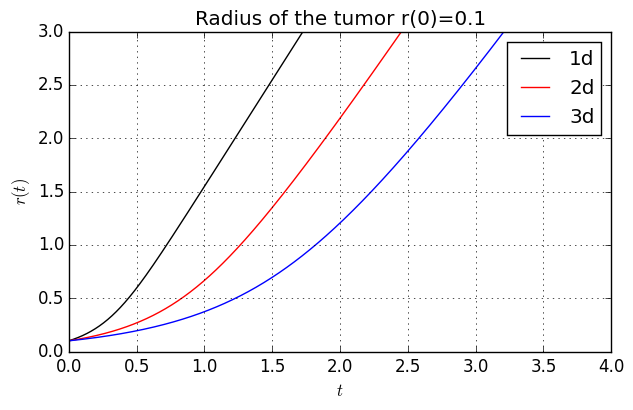

In [4]:
r0, rmax, β = .1, 3.,2
f(r,r0,d,λ) = log(((r./r0).^(d/2)).*besseli(d/2,β*r)./besseli(d/2,β*r0))./(β^2*λ)
R = linspace(r0,rmax,1000) # vector of radii

figure(figsize=[7,4])
plot(f(R,r0,1,1.),R,"k") # 1d
plot(f(R,r0,2,1.),R,"r") # 2d
plot(f(R,r0,3,1.),R,"b") # 3d
xlabel(L"t");ylabel(L"r(t)"); grid("on"); title("Radius of the tumor r(0)=$(r0)");
legend(["1d","2d","3d"],"north"); axis([0.; 4.; 0.; rmax]);

This plot also illustrates the fact that the asymptotic speed of the boundary does not depend on the dimension of the problem [Thm A.1, Perthame et al. '13] and is $r'(\infty)=2$. We will compare this results with the numerical ones.

## Scaling algorithm

The time-discretized gradient flow with time step $\tau$ (or Euler implicit scheme) is the sequence of measures, starting from $\rho_0 \in L^1_+(\Omega)$, defined as
\begin{equation}
\rho_{k+1} = \arg \min_{\rho} G(\rho) + \tfrac{1}{2\tau} KF(\rho_k,\rho)^2\, .
\end{equation}

This problem is solved efficiently by scaling algorithms for unbalanced optimal transport (see [Chizat et al, 16]). Namely, by denoting 
\begin{align}
F_1(p) &= \mathcal{H}(p|\rho_{k}) & F_2(p) &= \min_{q} \mathcal{H}(p|q) + 2\tau G(q)\\
\mathrm{prox}_F(x) &= \arg \min_y F(y)+ \mathcal{H}(y|x) & \mathrm{prodiv}_{F}(x) &= \mathrm{prox}_F(x)\oslash x\\
K(p)(x)  &= \int_{\Omega} e^{-c(x,y)/\epsilon} p(x) dx &
K'(p)(y)  &= \int_{\Omega} e^{-c(x,y)/\epsilon} p(y) dy 
\end{align}
where $\epsilon>0$ is a small parameter, the algorithm reads:
\begin{align}
a &\leftarrow \mathrm{prodiv}_{F_1/\epsilon}(K(b))\\
b &\leftarrow \mathrm{prodiv}_{F_2/\epsilon}(K'(a))
\end{align}

This algorithms outputs the new density $\rho_{k+1}$ but also the potential $v=\epsilon \log b$ and then $\phi=1-\exp(-v)$. Thus the pressure is available since $p=(2\tau-\phi)/(2\tau)$.

## Discretization and numerics for $\Omega = [0,1]$

The segment $\Omega=[0,1]$ is discretized into $\Omega_N = \left\{ \tfrac{i}{N}-\tfrac{1}{2N} : i=1,\dots,N\right\}$ endowed with the discretized Lebesgue measure (and similar discretization in 2d). We do the following comparisons between numerical and theoretical results:
- pressure in 1D
- $r'$ as a function of $r$ in 1d and 2d

Three effects combine to limit the precision of the computed flow:
- time discretization (parameter $\tau$)
- space discretization (parameter $N$)
- precision of the problem resolution (parameter $\epsilon$ and also implementation dependant `tol`, `niter`)

The relation between the values of these parameters is crucial: $1/N = O(\tau)$ (speed of propagation of the tumor) and $1/N^2 = O(\epsilon)$ (kernel matrix non singular). Convergence entropic JKO: $\epsilon = O(\tau^2)$.

In [5]:
# THE NUMERICAL BALL
"ball B(c,r) in [0,1]^d"
function ball(c,r;N=50) 
    X = linspace(.5/N,1-.5/N,N)
    if length(c) == 1
        return Float64[ abs(x-c[1])<=r for x in X]
    elseif length(c) == 2
        return Float64[(x-c[1])^2+(y-c[2])^2<r^2 for x in X, y in X]
    end
end

ball (generic function with 1 method)

### Compare pressure (1d)

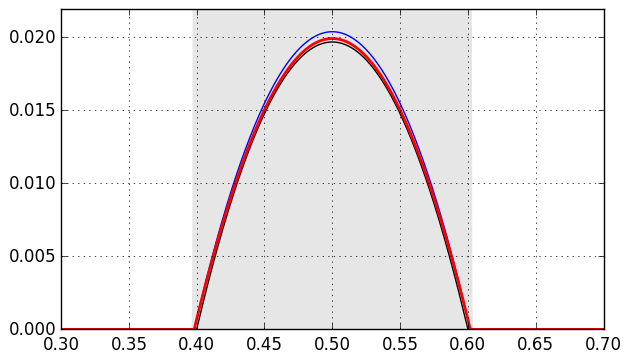

  7.006666 seconds (75.69 M allocations: 5.573 GB, 14.47% gc time)


In [211]:
# 10 seconds
dim, N, τ, ϵ = 1, 5000, 5e-3, 1e-6                      
p   = ball(.5, .1, N=N)[:]                           
@time q,pr_num = gradientflow.onestepflow(p, τ, dim, ϵ;
                                                    niter=300, walls=falses(p), epsstep=6., tol=1e-20);
pdim1(s,r,λ,β) = max(0,λ*(1-cosh(β*s)./cosh(β*r)))       # 1d theoretical pressure p(s) where s is distance from center

figure(figsize=[7,4])
X = linspace(.5/N,1-.5/N,N)
plot(X,pdim1(abs(X-.5),sum(p.>.5)/(2*N),1.,2),"-k",label=L"p_{k\tau}")
plot(X,pdim1(abs(X-.5),sum(q.>.5)/(2*N),1.,2),"-b",label=L"p_{(k+1)\tau}")
plot(X,pr_num,"r",linewidth=2,label=L"p_{num}")
fill(X,q,color=[.9,.9,.9],label=L"\mathrm{supp} \rho_{k\tau}")
grid("on"); axis([0.3 ; .7; 0.0 ; maximum(pr_num)*1.1]);
xlabel(L"X");  title("Pressure"); legend(loc="north"); 
#savefig("outputs/comparepressure1d.pdf");

### Compare pressure (2d)

In [234]:
# 250 seconds (or take N=200 @ τ = 5e-2 for faster computation)
dim, N, τ, ϵ = 2, 400, 3e-2, 4e-6                     
p   = ball([.5 .5], .3, N=N)[:]                           
@time q,pr_num = gradientflow.onestepflow(p, τ, dim, ϵ;
                                                    niter=300, walls=falses(p), epsstep=6., tol=1e-20);
pdim2(s,r,β) = max(0,1-besseli(0,β*s)./besseli(0,β*r))    # 2d theoretical pressure p(s) where s is distance from center

246.528518 seconds (1.67 G allocations: 151.347 GB, 21.51% gc time)


pdim2 (generic function with 1 method)

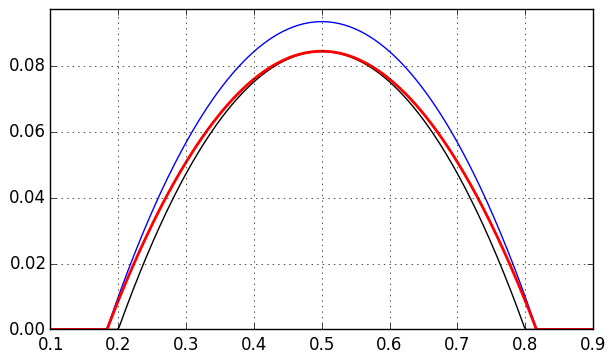

In [248]:
pr1 = reshape(pr_num,N,N)
pdiag = [pr1[i,i] for i = 1:N]
figure(figsize=[7,4])
X = linspace(.5/N,1-.5/N,N)
plot(X,pdim2(abs(X-.5),sqrt(sum(p)/(N^2*π)),2),"-k",label=L"p_{k\tau}")
plot(X,pdim2(abs(X-.5),sqrt(sum(q)/(N^2*π)),2),"-b",label=L"p_{(k+1)\tau}")
plot(X,pr1[:,div(N,2)],"r",linewidth=2,label=L"p_{num}")
#plot(.5+(X-.5)*sqrt(2),pdiag) # shows that pressure is symetrical
grid("on"); axis([0.1 ; .9; 0.0 ; maximum(pr_num)*1.15]);
#xlabel(L"X");  title("Pressure"); legend(loc="north"); 
#savefig("outputs/comparepressure2d.pdf");

### Compare speed of boundary (1d)

In [51]:
#30 seconds per radius
dim, N, τ, ϵ = 1, 2000, 5e-2, 2e-7
rvect = linspace(.01,.4,50)
rnext = zeros(rvect)
for i=1:length(rvect)
    print("\rCurrently computing i=$(i)")
    p = ball(.5, rvect[i], N=N)[:] 
    q,pr = gradientflow.onestepflow(p,τ,dim,ϵ;niter=200, walls=falses(p), epsstep=6., tol=1e-30);
    rnext[i]= sum(q.>.5)/(2*N)
end

Currently computing i=100

We can compute the theoretical speed through:
$$ r'(t) = \lambda\beta\frac{I_{d/2}(\beta r(t))}{I_{d/2-1}(\beta r(t))}$$

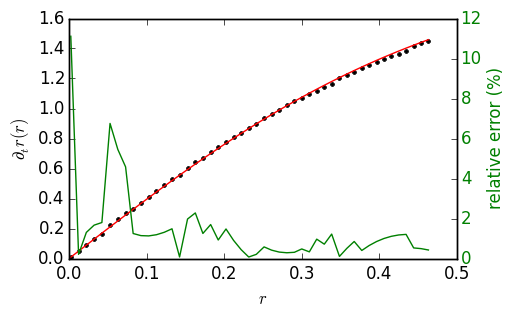

In [163]:
f(r,d) = 2*besseli(d/2,2r)./besseli(d/2-1,2r)
rm=5
ind=1:2:(length(rnext)-rm)
vvect  = (rnext[ind]-rvect[ind])/τ
rs     = (rnext[ind]+rvect[ind])/2
verr   = 100*abs(vvect-f(rs,1))./f(rs,1)
#write(file, "comparespeed1D", [rs vvect])

fig, ax1 = subplots(figsize=[5,3])
ax1[:plot](rs, vvect, "k.")
ax1[:plot](rs, f(rs,1), "r-")
ax1[:set_xlabel](L"r")
ax1[:set_ylabel](L"\partial_t r(r)")

ax2 = ax1[:twinx]()
ax2[:plot](rs, verr, "g")
ax2[:set_ylabel]("relative error (%)", color="g")
for tl in ax2[:get_yticklabels]()
    tl[:set_color]("g")
end
#show()

#savefig("outputs/speed1d.pdf")

This experiment shows that the quality decreases really when $\tau$ decreases; 

### Compare speed at boundary (2d)

In [293]:
# 30 seconds per radius
dim, N, τ, ϵ = 2, 256, 7e-2, 4e-6                     
rvect = linspace(.02,.4,20)
rnext = zeros(rvect)
for i=1:length(rvect)
    print("\rCurrently computing i=$(i)")
    p = ball([.5 .5], rvect[i], N=N)[:] 
    q,pr = gradientflow.onestepflow(p,τ,dim,ϵ;niter=400, walls=falses(p), epsstep=6., tol=1e-30);
    rnext[i]= sqrt(sum(q)/(N^2*π))
end

Currently computing i=20

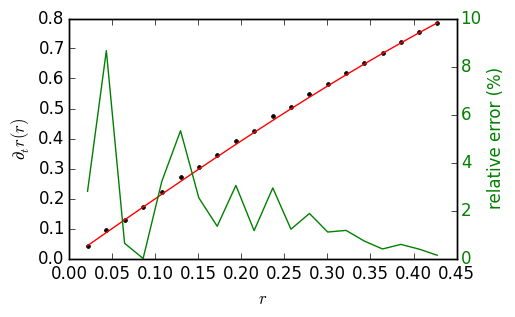

In [298]:
f(r,d) = 2*besseli(d/2,2r)./besseli(d/2-1,2r)
ind=1:length(rnext)
vvect  = (rnext[ind]-rvect[ind])/τ
rs     = (rnext[ind]+rvect[ind])/2
verr   = 100*abs(vvect-f(rs,2))./f(rs,2)
#write(file, "comparespeed2D", [rs vvect])

fig, ax1 = subplots(figsize=[5,3])
ax1[:plot](rs, vvect, "k.")
ax1[:plot](rs, f(rs,2), "r-")
ax1[:set_xlabel](L"r")
ax1[:set_ylabel](L"\partial_t r(r)")
ax1[:axis]([0,.45,0,.8])

ax2 = ax1[:twinx]()
ax2[:plot](rs, verr, "g-")
ax2[:set_ylabel]("relative error (%)", color="g")
ax2[:axis]([0,.45,0,10])
for tl in ax2[:get_yticklabels]()
    tl[:set_color]("g")
end
#show()
#savefig("outputs/speed2d.pdf")

## Numerics 2D multiscale

Now let's have some fun: evolution in 2D of a tumor in a domain which is not convex (the geodesic distance is approximated by the euclidean distance, still).

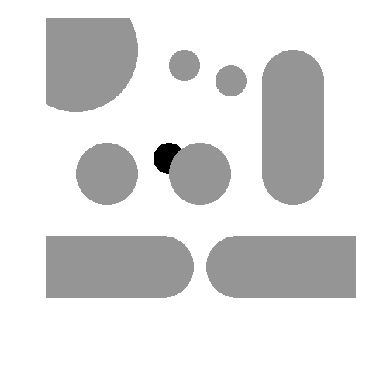

(0.0,400.0,0.0,400.0)

In [52]:
rh = .1 
# dim, N, τ, ϵ = 2, 200, 5e-2, 4e-6 (simu A)
dim, N, τ, ϵ = 2, 400, 4e-2, 2e-6
p   =   max(ball([.55 .4], .05, N=N)- ball([.5 .5], rh, N=N),0)
walls = min(1,ball([.5 .2], rh, N=N)+ball([.9 .1], rh*2, N=N)+ball([.85 .45], rh/2, N=N)+
        ball([.2 .38], rh, N=N)+ball([.5 .5], rh, N=N)+ball([.8 .6], rh/2, N=N)+
        ball([.2 .62], rh, N=N)+ball([.5 .8], rh, N=N)+ball([.8 .8], rh, N=N)+
        Float64[(.2-rh<x<.2+rh)&&(y<.38) for x in linspace(.5/N,1-.5/N,N), y in linspace(.5/N,1-.5/N,N)]+
        Float64[(.2-rh<x<.2+rh)&&(.62<y) for x in linspace(.5/N,1-.5/N,N), y in linspace(.5/N,1-.5/N,N)]+
        Float64[(.5<x<.8)&&(.8-rh<y<.8+rh) for x in linspace(.5/N,1-.5/N,N), y in linspace(.5/N,1-.5/N,N)])
figure(figsize=[4,4])
pcolormesh(walls+2*p,cmap="Greys");axis("equal"); axis("off")

In [182]:
nstep=55
flow, pr = fill(p[:], nstep+1), fill(p[:], nstep+1)
pr[1]=zeros(pr[1])
for k = 1:nstep
    @time (flow[k+1],pr[k+1])  = gradientflow.onestepflow(flow[k],τ,dim,ϵ;
                                        niter=400, walls=map(Bool,walls[:]), epsstep=6., tol=1e-20)
    println("k = ",k,"/$(nstep)")
end

 33.639432 seconds (371.17 M allocations: 23.391 GB, 10.84% gc time)
k = 1/55
 34.834961 seconds (374.56 M allocations: 23.787 GB, 11.18% gc time)
k = 2/55
 34.074048 seconds (376.31 M allocations: 24.024 GB, 11.09% gc time)
k = 3/55
 33.293237 seconds (378.71 M allocations: 24.338 GB, 10.84% gc time)
k = 4/55
 34.793659 seconds (381.54 M allocations: 24.721 GB, 11.59% gc time)
k = 5/55
 35.969243 seconds (385.03 M allocations: 25.176 GB, 10.08% gc time)
k = 6/55
 36.503186 seconds (388.47 M allocations: 25.639 GB, 12.54% gc time)
k = 7/55
 35.623526 seconds (393.08 M allocations: 26.233 GB, 11.16% gc time)
k = 8/55
 37.976209 seconds (397.56 M allocations: 26.831 GB, 11.25% gc time)
k = 9/55
 38.369552 seconds (403.13 M allocations: 27.568 GB, 11.67% gc time)
k = 10/55
 37.561456 seconds (409.50 M allocations: 28.405 GB, 11.26% gc time)
k = 11/55
 41.888755 seconds (416.39 M allocations: 29.324 GB, 11.13% gc time)
k = 12/55
 40.498191 seconds (424.06 M allocations: 30.338 GB, 10.88% g

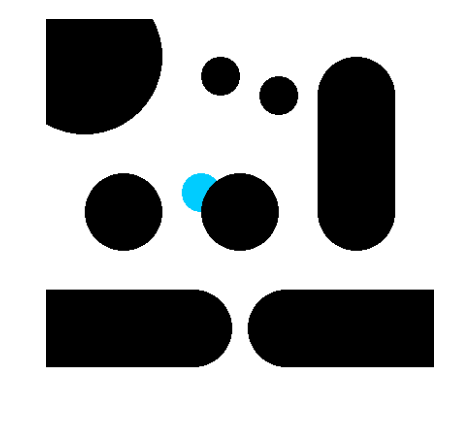

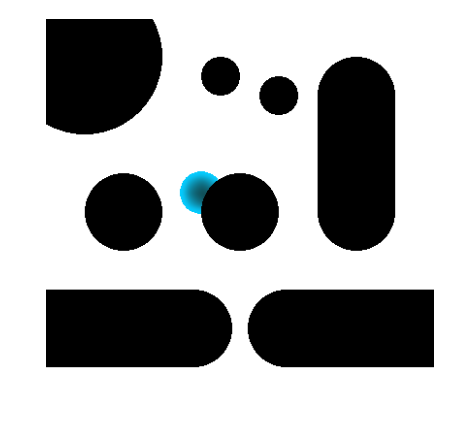

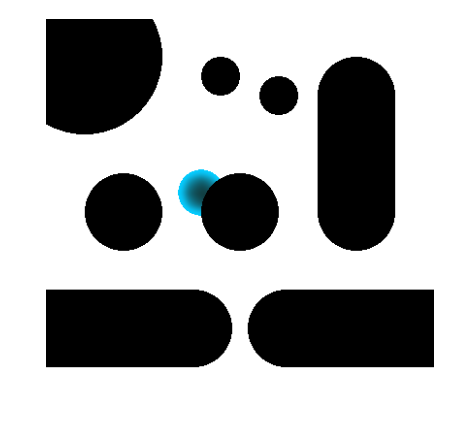

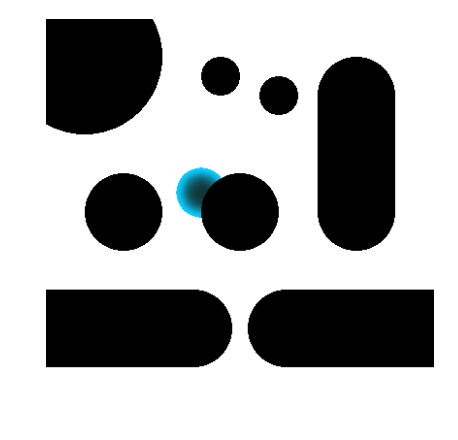

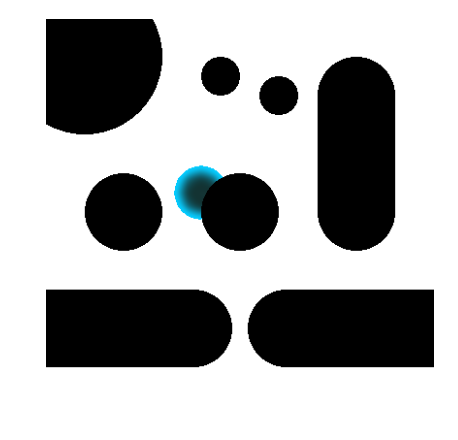

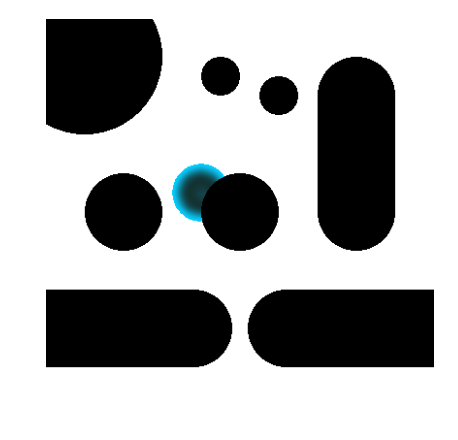

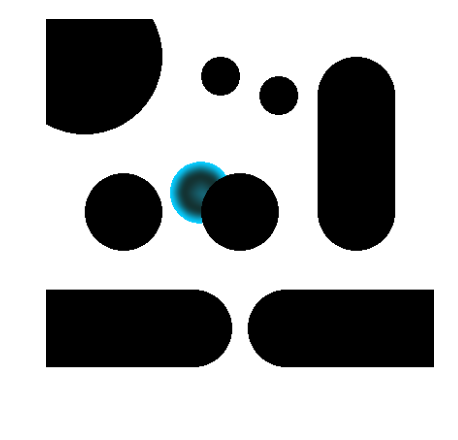

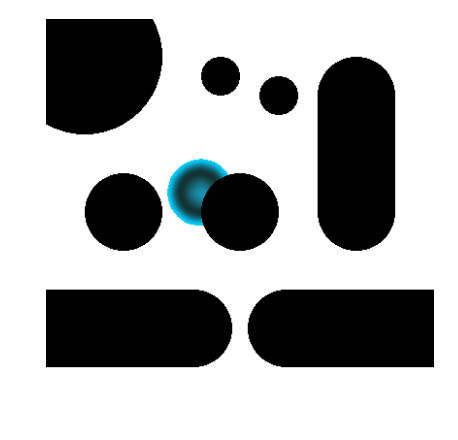

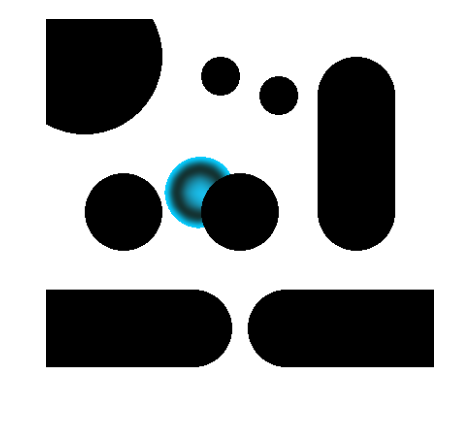

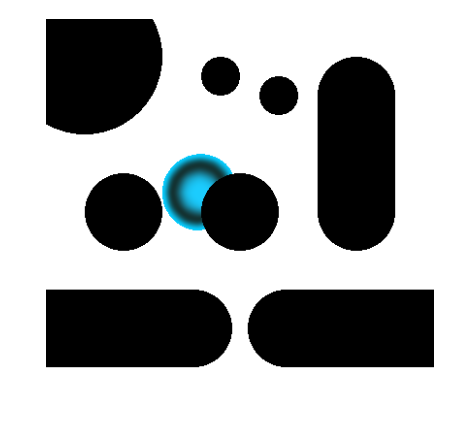

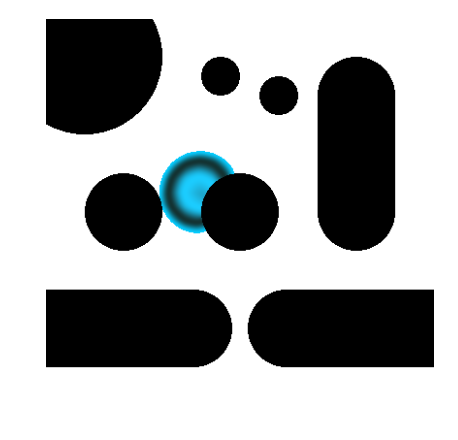

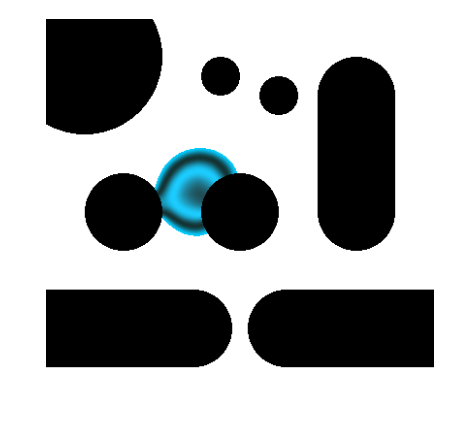

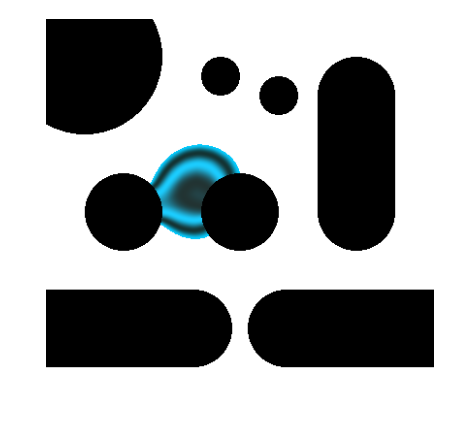

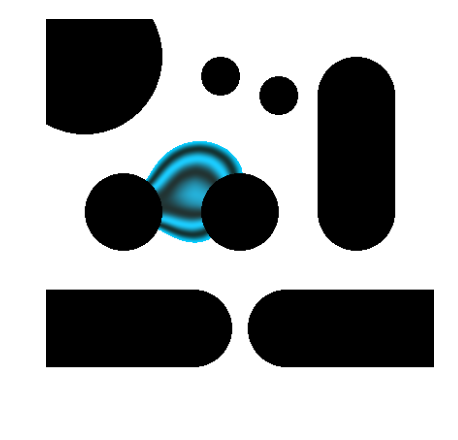

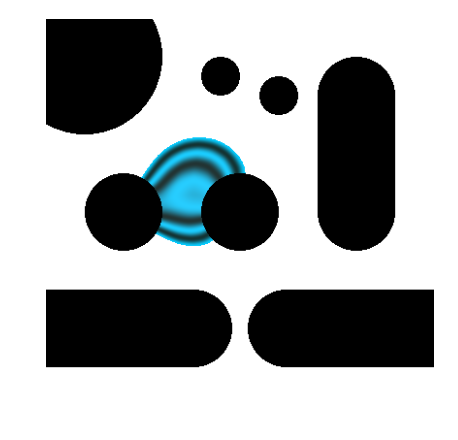

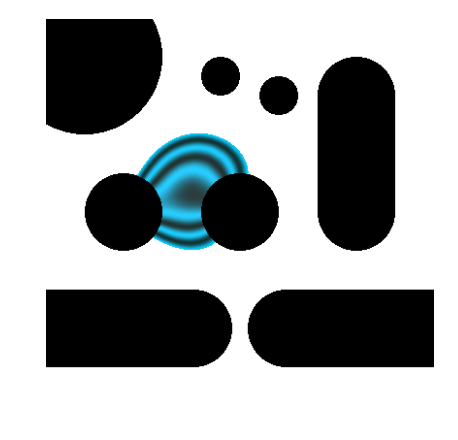

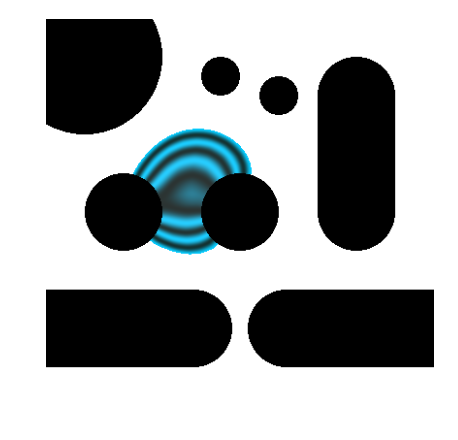

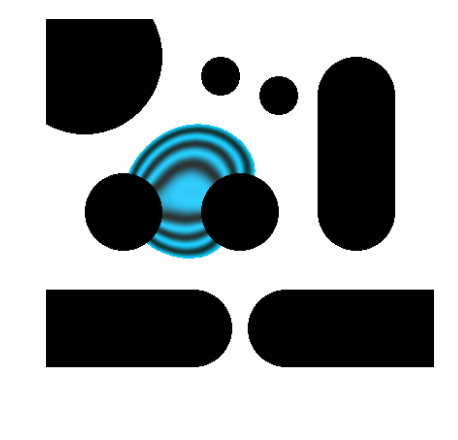

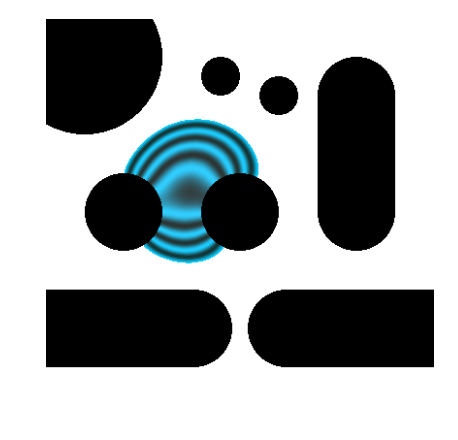

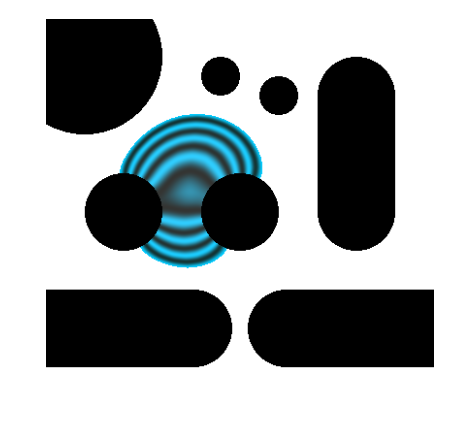

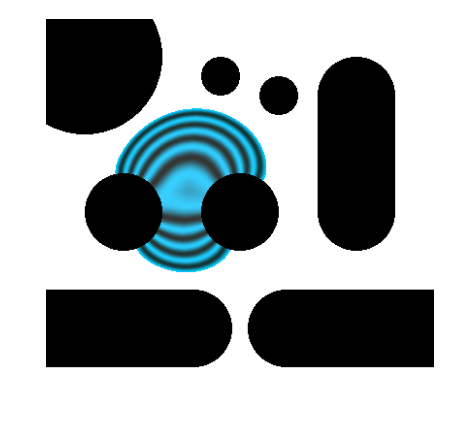

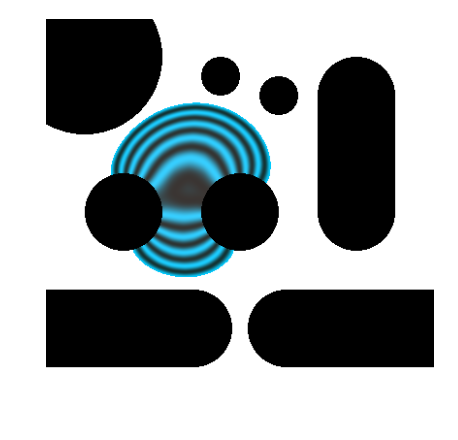

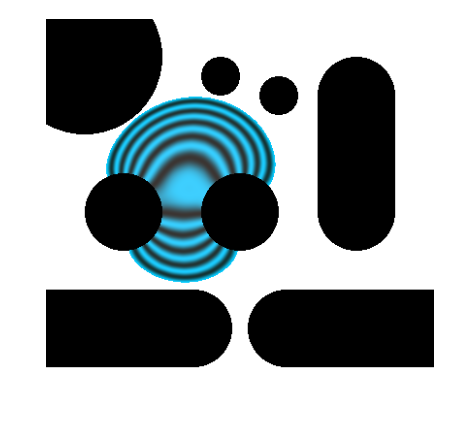

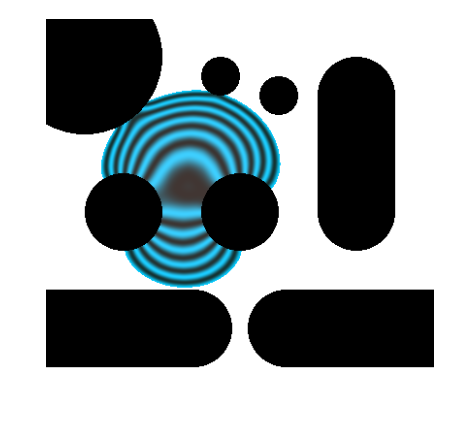

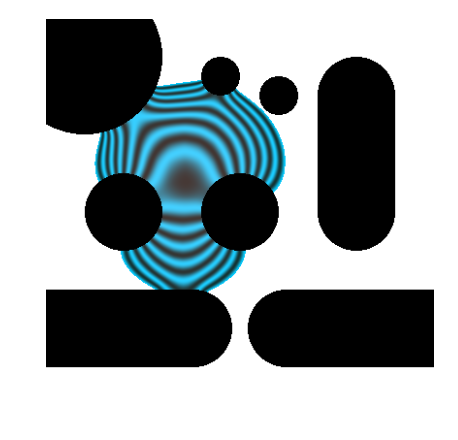

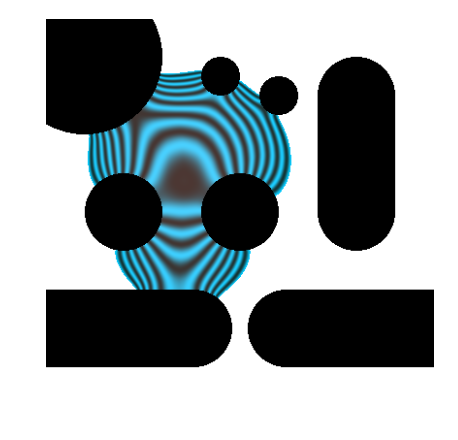

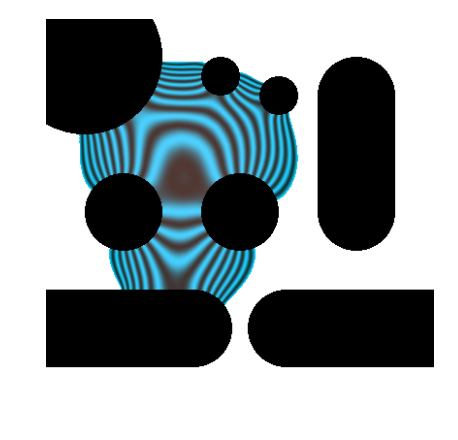

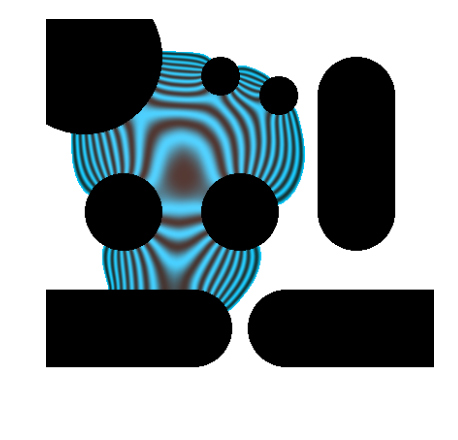

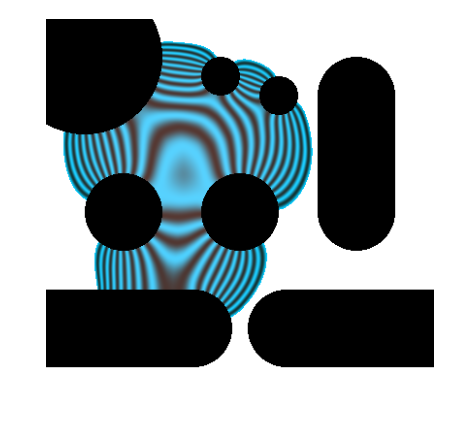

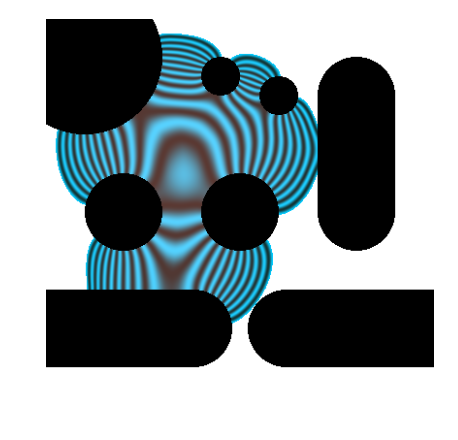

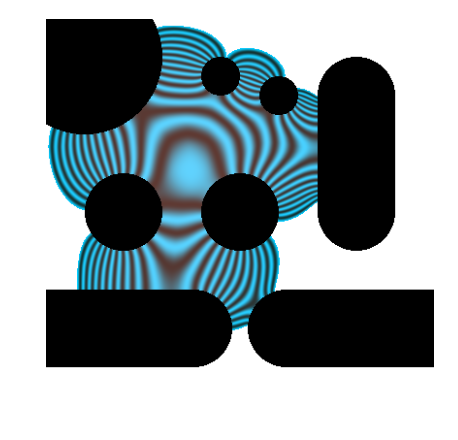

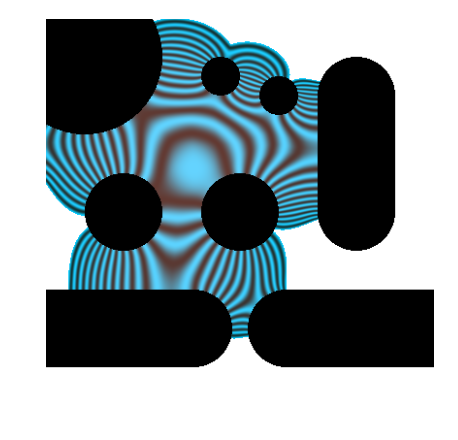

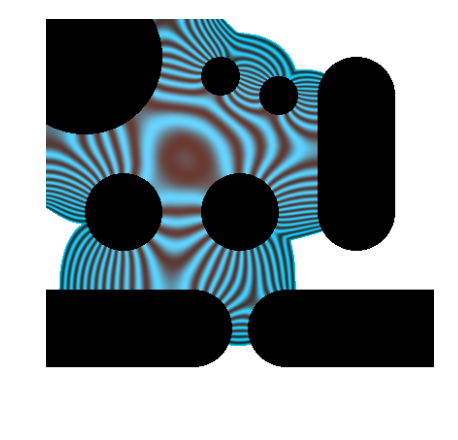

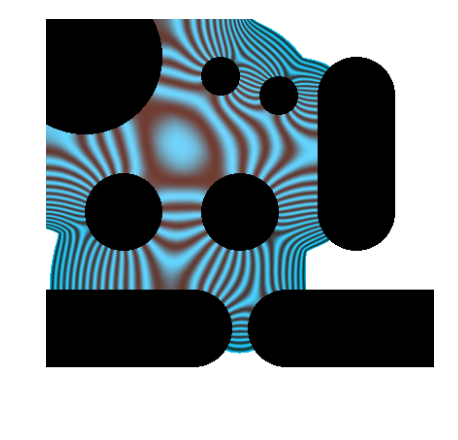

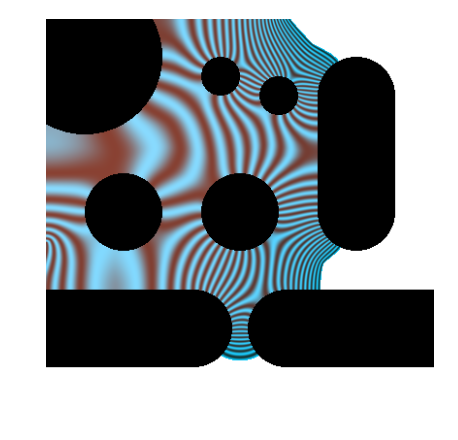

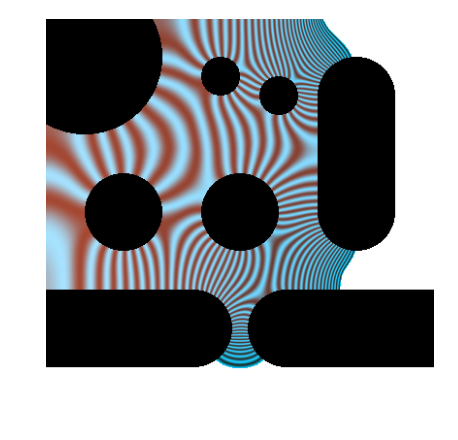

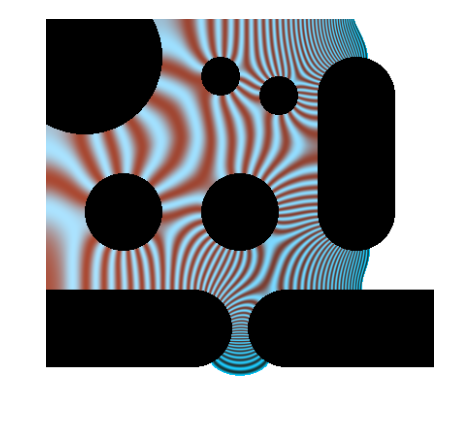

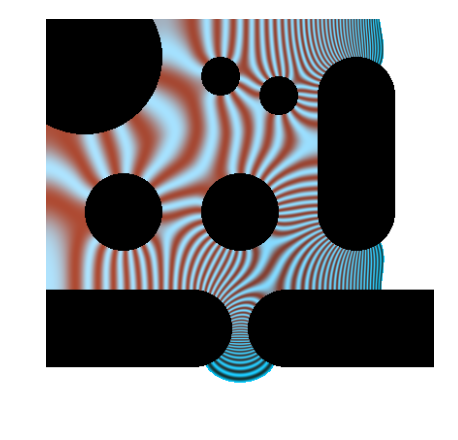

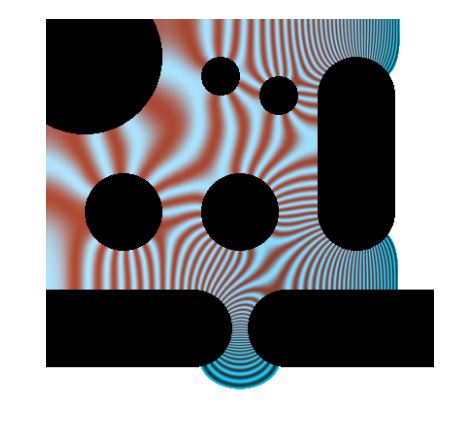

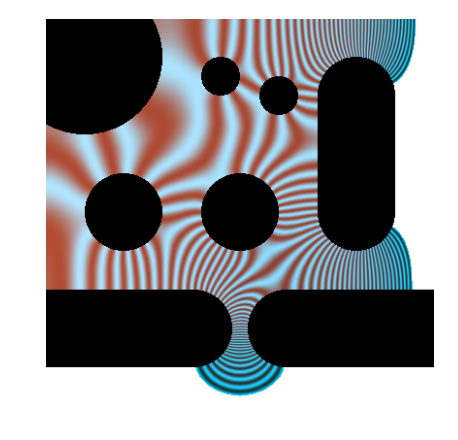

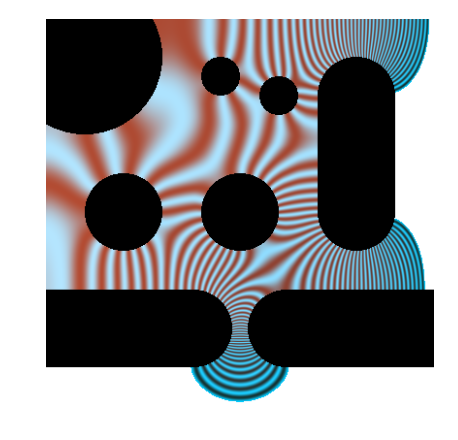

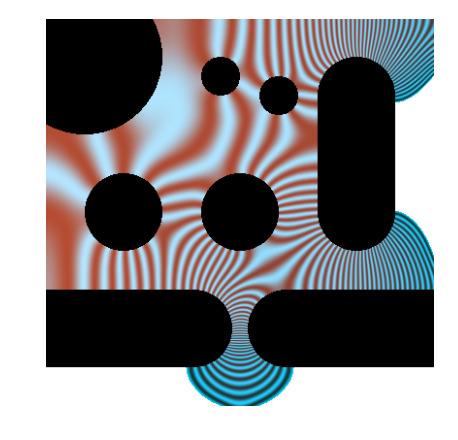

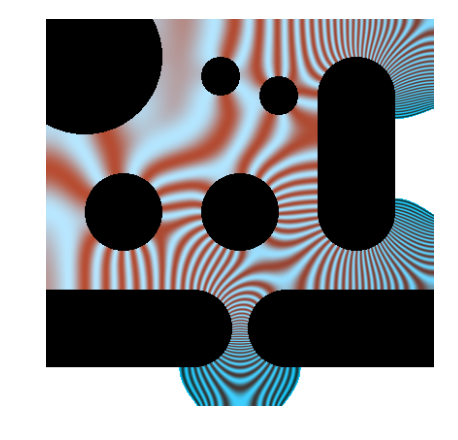

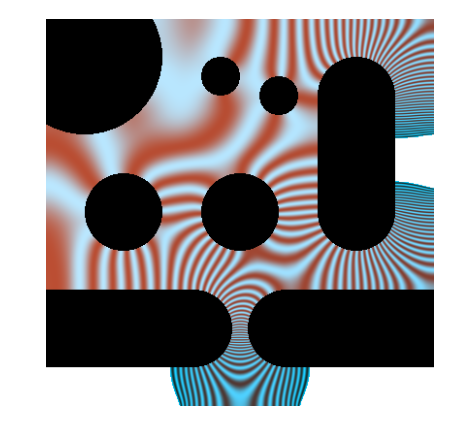

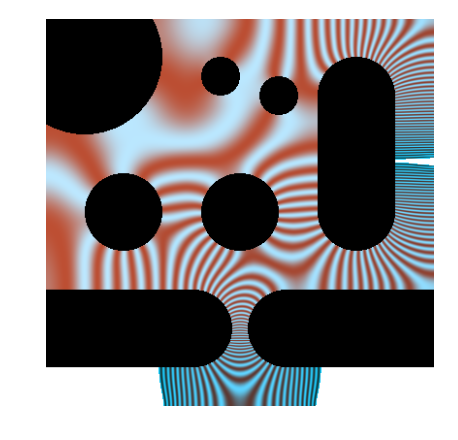

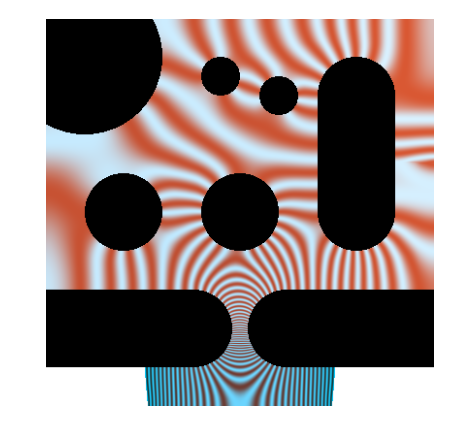

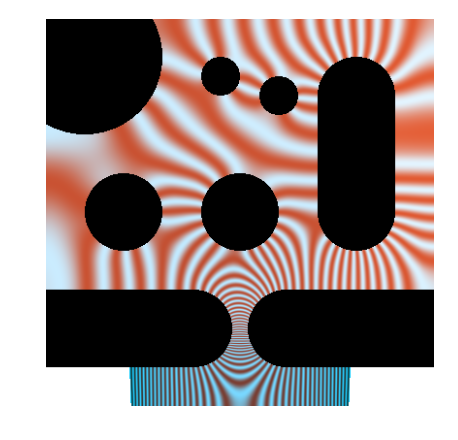

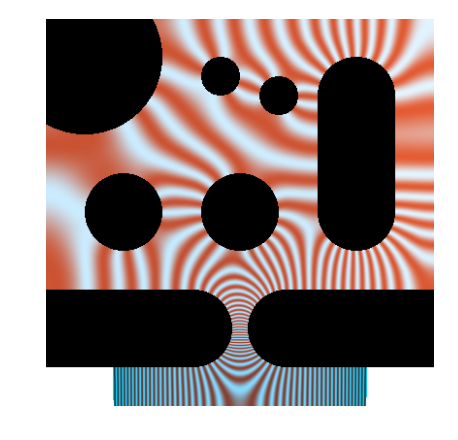

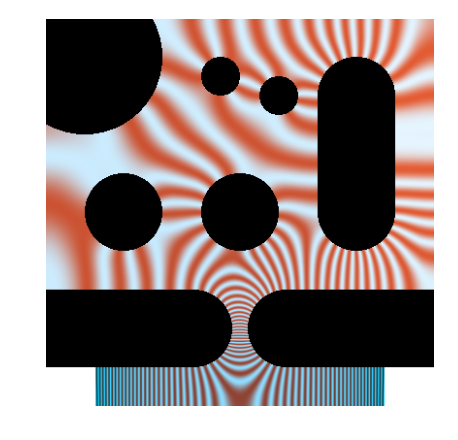

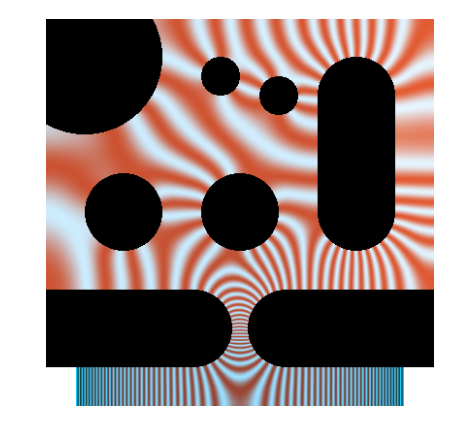

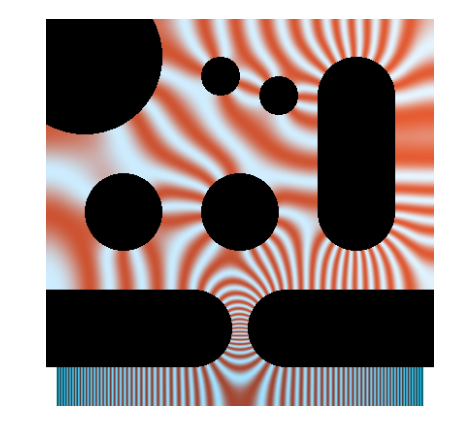

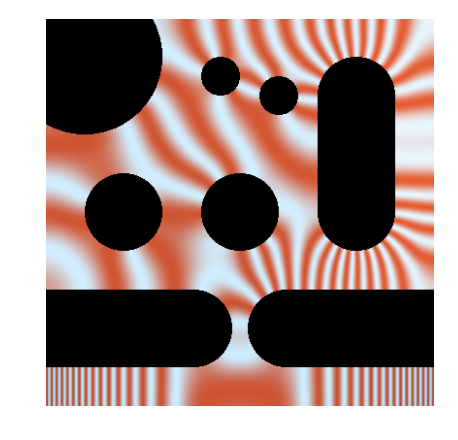

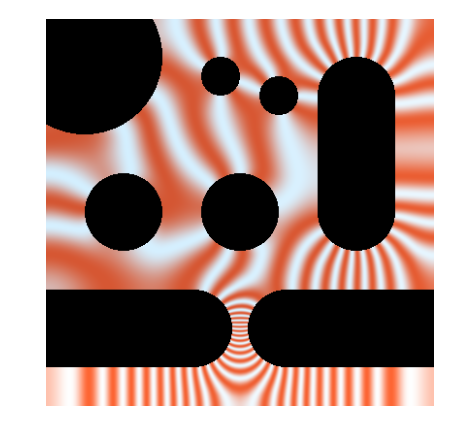

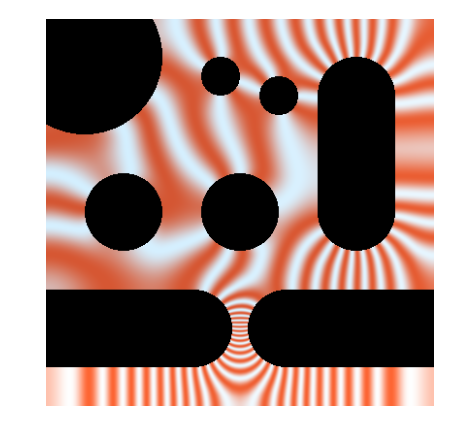

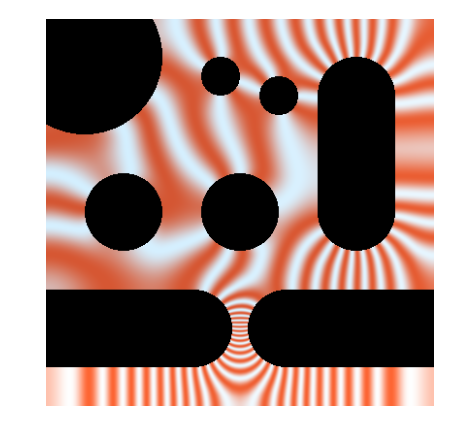

In [350]:
k=50
m = maximum([maximum(pr[i][pr[i].<Inf]) for i=1:length(pr)])
#for k=1:nstep
pp = pr[k]
pp[pr[k].==Inf]=0.
pp = cat(2,linspace(0,1,100),linspace(0,1,100))
#R,G,B=pp/m,.3+.3*cos(800*(pp)),.6+.3*cos(800*(pp)) #tres bien
R,G,B=(abs(pp)/m).^(1/2),.5+.2*(abs(pp)/m)+.3*cos(800*(pp)),.6+.4*cos(800*(pp))
#R,G,B=.3*ones(pp),.5*ones(pp),.8*ones(pp)
    #qq=pp[k]
R[flow[k].<.2]=1.
G[flow[k].<.2]=1.
B[flow[k].<.2]=1.
w = map(Bool,walls)[:]
R[w]=0.
G[w]=0.
B[w]=0.
figure(figsize=[5,5],frameon=true)
imshow(cat(3,reshape(R,N,N),reshape(G,N,N),reshape(B,N,N)),origin="lower");
#pcolormesh(reshape(pp,N,N))
axis("off")
    #pcolor(reshape(R,N,N))
    #pcolormesh(reshape(qq,N,N),vmin=-.2,vmax=0.77);axis("equal"); 
#    savefig("flow2d_Balt$(k)");
#end


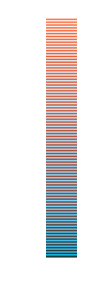

In [377]:
hh,ll = 400, 10
pp = repmat(linspace(0,m,hh),1,ll)
R,G,B=(abs(pp)/m).^(1/2),.5+.2*(abs(pp)/m)+.3*cos(800*(pp)),.6+.4*cos(800*(pp))
figure(figsize=[4,3])
imshow(cat(3,reshape(R,hh,ll),reshape(G,hh,ll),reshape(B,hh,ll)),origin="lower",aspect=.2);axis("off")
savefig("colorbar0_06");